## Paso 1: Efecto de tratamiento promedio (ATE)

Algo que dificulta la inferencia causal es el sesgo, pero este puede ser eliminado randomizando los datos gracias a la eliminación de variables confusas (llamado confounding).

Al randomizar los descuentos asignados, se logra aislar el efecto de los descuentos sobre las utilidades, y esto permite comparar clientes con descuentos altos con clientes con descuentos bajos, así al ver la diferencia en las utilidades puede ser atribuidas solamente al cambio en los descuentos, el comparar la diferencia promedio correspondiente a los descuentos entre la relación de datos randomizados con no randomizados se le llama *Efecto de tratamiento promedio* o Average Treatment Effect (ATE por sus siglas en inglés).

Se generará una pendiente del coeficiente de regresión al cual nos referiremos como efecto causal linear, con descuentos randomizados, estimar el ATE será sencillo.

Text(0.5, 1.0, 'Relación entre descuentos y utilidades en datos randomizados')

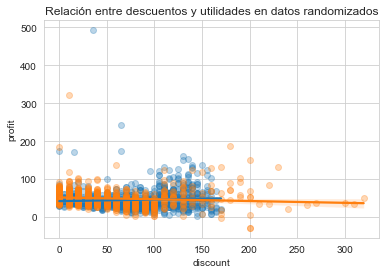

In [9]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf

from lightgbm import LGBMRegressor
from sklearn.metrics import r2_score

train = pd.read_csv("non_rand_discount.csv", sep=";")
test = pd.read_csv("random_data.csv")

train["discount"] = train["discount"].str.split(" ").str[-1].astype(float)
np.random.seed(123)
sns.regplot(data = train.sample(1000), x="discount", y="profit", scatter_kws={"alpha":0.3})
plt.title("Relación entre descuentos y utilidades en datos no randomizados")

np.random.seed(123)
sns.regplot(data = test.sample(1000), x="discount", y="profit", scatter_kws={"alpha":0.3})
plt.title("Relación entre descuentos y utilidades en datos randomizados")

La primera gráfica muestra una relación positiva entre descuento y utilidad, no se puede decir que es una relación causal porque puede haber variables confusas que no se estén tomando en consideración.

La segunda gráfica muestra la relación negativa entre descuento y utilidad, ya que el descuento fue asignado de manera aleatoria, se puede decir que la relación captura el efecto causal entre descuento y utilidad.

In [10]:
def elast(data, t, y):
    cov_matrix = np.cov(data[y], data[t])
    return cov_matrix[1, 0] / cov_matrix[1, 1]
print("ATE del descuento en ventas:", elast(test, "discount", "sales"))
print("ATE del descuento en utilidades:", elast(test, "discount", "profit"))
print("Relación entre descuento y ventas:", elast(train, "discount", "sales"))
print("Relación entre descuento y utilidades:", elast(train, "discount", "profit"))

ATE del descuento en ventas: 19.28676541602892
ATE del descuento en utilidades: -0.035661126707360505
Relación entre descuento y ventas: 21.92480631346764
Relación entre descuento y utilidades: 0.07431475005627197


Al observar el coeficiente de regresión entre descuentos y ventas, muestra que una unidad de descuento incrementa las ventas, pero sabemos que las utilidades se presentan a partir de:

$$
Utilidad_i = Ventas_i * 5\% - Descuento_i
$$

Significa que para incrementar la utilidad, 1 unidad de descuento tiene que incrementar las ventas por más de 20 unidades ($1/0.05 = 20$) pero como eso no está ocurriendo, la aplicación de descuentos actuales no lleva a mejorar las ganancias.

## Paso 2: Tratamiento continuo

Para poder realizar un efecto de tratamiento de forma continua que conlleve a mejorar las ganancias, necesitamos crear un modelo linear para realizar predicciones de utilidades usando el set de datos de prueba randomizados, seguido por substraer 1 de los descuentos dados en el set y realizar predicciones de nuevo y obtener el tratamiento de efecto predictivo substrayendo una la primera predicción de la segunda dado que este es un modelo linear, representado como TE con la siguiente fórmula:

$$
TE_i = Modelo(testData_i,Descuento_i) − Modelo(testData,Descuento_i − 1)
$$

Ahora que ya se obtuvo el tratamiento predictivo TE, se evalúa el desempeño usando la edad como un "score" de personalización.

nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan


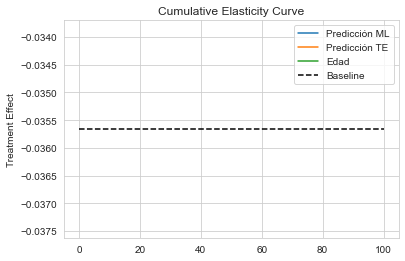

In [16]:
# Definimos la generación de la curva de elasticidad acumulada que representa de forma gráfica
# la elasticidad financiera por segmento para las predicciones de TE
def te(df, t, y):
    print(df.query(f"{t}==1")[y])
    return df.query(f"{t}==1")[y].mean() - df.query(f"{t}==0")[y].mean()

def cumulative_elast_curve(dataset, prediction, y, t, steps=100, ascending=False):
    size = dataset.shape[0]
    ordered_df = dataset.sort_values(prediction, ascending=ascending).reset_index(drop=True)
    return np.array([te(ordered_df.query(f"index<={row}"), t=t, y=y)
                     for row in range(size//steps, size+1, size//steps)])

# Datos a utilizar
X = list(train.drop(columns=['sales', 'profit', "cust_state", "discount", "sales_prediction_bins", "sales_prediction"]).columns)
Y = "sales"

# Randomización de datos y creación del modelo linear
np.random.seed(123)
pred_m = LGBMRegressor(max_depth=3)
pred_m.fit(train[X], train[Y])
train_pred = train.assign(prediction = pred_m.predict(train[X]))
test_pred = test.assign(prediction = pred_m.predict(test[X]))
test_pred["binary_discount"] = np.where(test_pred["discount"] > 30, 1, 0)

teh_model = smf.ols("profit~discount*(tenure+age+C(cust_state))", data=train).fit()
test_te = teh_model.predict(test) - teh_model.predict(test.assign(discount=test["discount"]-1))

test_pred["teh_model"] = test_te

#Muestra la elasticidad financiera para comprobar si la segmentación por edad es efectiva
cum_elast_teh = cumulative_elast_curve(test_pred, "teh_model", y="profit", t="discount")
cum_elast_prediction = cumulative_elast_curve(test_pred, "prediction", y="profit", t="discount")
cum_elast_age = cumulative_elast_curve(test_pred, "age", y="profit", t="discount")

# print(cum_elast_teh)
# print(cum_elast_prediction)
# print(cum_elast_age)

plt.plot(cum_elast_prediction, label="Predicción ML")
plt.plot(cum_elast_teh, label="Predicción TE")
plt.plot(cum_elast_age, label="Edad")

plt.hlines(elast(test_pred, "discount", "profit"), 0, 100, linestyle="--", color="black", label="Baseline")
plt.ylabel("Treatment Effect")
plt.title("Cumulative Elasticity Curve")
plt.legend();

La curva de elasticidad acumulada muestra que el TE del modelo linear empieza lejos del ATE y lentamente converge con él, esto significa que el modelo es mejor distinguiendo clientes con un TE alto que los de un TE bajo, esto valida que nuestro modelo linear predictivo es mejor para identificar la aplicación efectiva de descuentos con inferencia causal que usar simple segmentación (por edad en este ejemplo).

## Paso 3: Aplicación del descuento

